In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from utils import network_from_raw_data
from semi_metric_topology import create_synthetic_network, semi_metric_topology
from si_dynamics import get_si_results

# Synthetic network with tunable metric backbone and semi-metric distortion distribution from an empirical network

First thing, we'll do is get a sample empirical transportation network

In [2]:
city = 'Albany'
mobilitydef = network_from_raw_data(city)

Then we compute its semi-metric topology, i.e. identify the edges in the metric backbone and the semi-metric distortions of those not in the metric backbone

In [3]:
network = semi_metric_topology(mobilitydef) 
network.to_csv('Data/network_with_semi_metric_topology_%s.csv'%city,index=False)
network

,source,target,distance,s_value,metric_distance,proximity,metric
0,12007,12054,6218.0,17.607412,353.146735,0.000161,False
1,12007,12203,17728.0,43.986493,403.032811,0.000056,False
2,12007,12206,10657.0,25.699504,414.677262,0.000094,False
3,12007,12305,9671.0,20.393228,474.226042,0.000103,False
4,12007,12208,19158.0,49.883036,384.058423,0.000052,False
...,...,...,...,...,...,...,...
4617,12022,12040,162.5,1.024294,158.645833,0.006116,False
4618,12064,12076,208.0,1.536643,135.360000,0.004785,False
4619,12076,12131,176.0,1.984366,88.693333,0.005650,False
4620,12076,12194,99.0,2.215095,44.693333,0.010000,False


As you can see in the dataframe above, the edge from $12131$ to $12194$ is in the backbone (*metric* is $True$ and *s_value* is $1.0$).
In contrast, the edge from $12076$ to $12194$ is not in the backbone (*metric* is $False$ and *s_value* is $2.215$). In fact the measured distance between those nodes is $99$ while the shortest path length is $44.693$, a distortion $2.215$ times the shortest path length to the measured distance.

### Getting the metric backbone

In [4]:
metric_network = network[network['metric']==True]
G_metric = nx.from_pandas_edgelist(metric_network, source='source', target='target', 
                                   edge_attr=['distance','proximity','metric_distance','s_value','metric'])

Once we have the metric backbone we can use it to compute the closure and afterwards generate a synthetic network.

In [5]:
tau = 0.10 ## Relative size of the backbone
mu = 1 ## Log median of the lognormal distribution
sigma = 1 ## Scale parameter
G_synthetic = create_synthetic_network(G_metric, tau, mu, sigma) ## Networkx graph with the synthetic network created
df_synthetic = nx.to_pandas_edgelist(G_synthetic) ## Dataframe with the synthetic network

### Perform SI dynamics

In [6]:
realizations=30 ### Number of outbreaks simulated for each infectious seed
beta=0.5 ### Infectiousness parameter
dt=0.1 ### Duration of each time step
chi_values = np.arange(0,1.01,0.05) ## chi controls the size of the sparsified network. Fraction of semi-metric edges remaining in the network after sparsifying. chi=1 original network, chi=0 metric backbone

df_results = get_si_results(city, realizations, beta, dt, chi_values)
df_results.to_csv('Data/si_dynamics_%s.csv'%city,index=False)

### Plot results of SDS

In [7]:
#chi_values=np.arange(0.0,1.01,0.05)
network_names=['Albany']
results_ratio=pd.DataFrame()
for network in network_names:
    results=pd.DataFrame()
    for chi in chi_values:
        results_partial=df_results[df_results['size']==chi]
        results_partial['t_half']=[results_partial['times'].values[i][4] for i in range(len(results_partial))]## if obtaining results as a variable within the notebook
        #results_partial['t_half']=[results_partial['times'].values[i].split(',')[4] for i in range(len(results_partial))] ### if reading the results from a file
        results_partial['t_half']=results_partial['t_half'].astype(float)
        results_partial['seed']=results_partial['seed'].astype(int)
        #results_partial=results_partial.groupby(['seed','size','network','option'])['t_half'].mean().reset_index()
        results_partial=results_partial.groupby(['seed','size','network']).agg({'t_half':'median'}).reset_index() ## for each seed get the median of the distribution as the typical time for the disease to reach half of the population
        #results=results.append(results_partial)
        #### NOTE: UPDATED TO THE NEW PANDAS VERSION
        results=pd.concat([results, results_partial])
    results_original=results[results['size']==1]
    results_original=results_original.rename(columns={'t_half':'t_half_original'})
    results_original=results_original[['seed','t_half_original']]
    results_def=pd.merge(results,results_original,on=['seed'])
    results_def['ratio']=results_def['t_half']/results_def['t_half_original']
    results_def['size']=results_def['size'].astype(float)
    
    results_def=results_def.groupby(['size']).agg({'ratio':['mean','median','std']}).reset_index()
    count_linestyle=0
    
    results_def['network']=network.replace('_','/')
    #results_ratio=results_ratio.append(results_def)
    #### NOTE: UPDATED TO THE NEW PANDAS VERSION
    results_ratio=pd.concat([results_ratio, results_def])
results_ratio.columns=results_ratio.columns.to_flat_index()
results_ratio.columns=['size','ratio_mean','ratio_median','ratio_std','network']

/tmp/ipykernel_10088/4253614268.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_partial['t_half']=[results_partial['times'].values[i][4] for i in range(len(results_partial))]## if obtaining results as a variable within the notebook
/tmp/ipykernel_10088/4253614268.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_partial['t_half']=results_partial['t_half'].astype(float)
/tmp/ipykernel_10088/4253614268.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

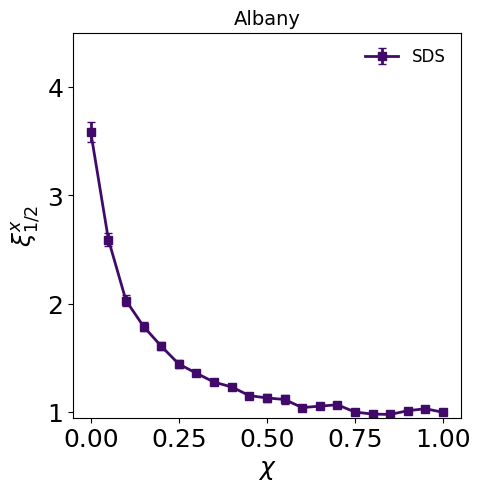

In [8]:
linestyle={'s_value':'solid'}
colors={}
labels={'s_value':'SDS'}
colors_n=plt.cm.inferno([0.2])
for i in range(len(colors_n)):
    colors[list(linestyle.keys())[i]]=colors_n[i]
fig,ax=plt.subplots(1,1,figsize=(5,5))
results_ratio['ratio_std']=results_ratio['ratio_std'].astype(float)
results_ratio['ratio_mean']=results_ratio['ratio_mean'].astype(float)
ax.errorbar(results_ratio['size'],results_ratio['ratio_mean'],yerr=results_ratio['ratio_std'].astype(float)/np.sqrt(30),lw=2,color=colors['s_value'],label=labels['s_value'],marker='s',capsize=3,elinewidth=2)
ax.tick_params(which='major',axis='both',labelsize=18) 
ax.set_xlabel(r'$\chi$',fontsize=18)
ax.set_ylabel(r'$\xi_{1/2}^{x}$',fontsize=18)
ax.set_title(network.replace('_','/'),fontsize=14)
ax.legend(frameon=False,fontsize=12)

ax.set_ylim(0.95,4.5)
#ax.text(0.05,1.10, 'a)', transform=ax.transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
plt.show()
